In [2]:
import os

os.environ["QUIMB_NUM_THREAD_WORKERS"] = "1"
import sys

sys.path.append("../../src")
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pylab as plt
import matplotlib.font_manager as fm


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
plt.rcParams.update({'font.size': 20})

In [48]:
from utilities import *
from preprocess import (
    shadow_results_to_data_vec,
    shadow_seqs_to_op_array_rz,
    shadow_seqs_to_op_array,
    pure_measurement,
    clifford_rz_unitaries_vT,
    clifford_measurements_vT,
    clifford_unitaries_vT,
    val_rz_unitaries_vT,
    val_unitaries_vT,
    val_measurements_vT,
    clifford_param_dict,
    validation_param_dict,
    op_arrays_to_single_vector_TN_padded_X_decomp,
)

from optimize import TNOptimizer
from fit_functions import (
    compute_likelihood,
    causality_keys_to_op_arrays,
    compute_probabilities,
)

from process_tensor_networks import (
    create_PT_PEPO_guess,
    expand_initial_guess_,
    create_PEPO_X_decomp,
    produce_LPDO,
)

In [5]:
import quimb as qu
import quimb.tensor as qtn
import seaborn as sns
import scipy
from scipy.stats import describe
import numpy as np

import qiskit
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.standard_errors import (
    depolarizing_error,
    coherent_unitary_error,
)
from qiskit.circuit import Parameter, ParameterVector
from qiskit import Aer
from qiskit.quantum_info.operators.operator import Operator
from qiskit import QuantumCircuit, transpile

In [6]:
simulator = Aer.get_backend("aer_simulator_density_matrix")

noise_model = noise.NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), "u2")
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), "u3")
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), "cx")

In [8]:
NSTEPS = 9
nQ = 1
basis_gates = ["cx", "rz", "sx", "x", "unitary"]

In [10]:
def create_env_IA(rxx, ryy, rzz):
    U = scipy.linalg.expm(
        -1.0j * 0.5 * (rxx * np.kron(X, X) + ryy * np.kron(Y, Y) + rzz * np.kron(Z, Z))
    )

    U = qiskit.quantum_info.operators.operator.Operator(U, 4, 4)
    return U

In [11]:
def append_PT_gates(circ, timesteps, q_sys, IA):
    """
    Function for the in-place insertion of the parametrised DD sequence into a circuit.

    circ : QuantumCircuit
        Broader circuit into which we're appending our sequence.
        This function should be called at the appropriate gap.

    timesteps : int
        Number of gates to include.
        Modifiable for future, but should be kept at 6 for now (one input, 4 DD, one measure basis)

    q_sys : int
        System (target) qubit from the broader circuit

    tau : int
        Length of the delay gate between pulses, in units of dt.
        Currently structured U0 -- tau -- U1 -- 2*tau -- U2 -- 2*tau -- U3 -- tau -- U4 -- Measure

    """

    param_list = [
        [Parameter(f"t{i}_x"), Parameter(f"t{i}_y"), Parameter(f"t{i}_z")]
        for i in range(timesteps)
    ]

    # can modify circuit structure here if desired
    circ.u(param_list[0][0], param_list[0][1], param_list[0][2], q_sys)

    for i in range(1, timesteps - 1):
        circ.append(IA, [0, 1])
        circ.u(param_list[i][0], param_list[i][1], param_list[i][2], q_sys)
        circ.append(IA, [0, 1])

    circ.u(param_list[-1][0], param_list[-1][1], param_list[-1][2], q_sys)
    circ.measure(q_sys, 0)

    return None

In [16]:
def base_PT_circ_template(qubit_list, timesteps, IA, backend):
    """
    Create the QuantumCircuit of interest. This template leaves the DD sequence parametrised for later
    process tensor or other validation circuits

    qubit_list : list
        List of physical qubits for passing to the transpilation function

    timesteps : int
        Number of gates to include.
        Modifiable for future, but should be kept at 6 for now (one input, 4 DD, one measure basis)

    tau : int
        Length of the delay gate between pulses, in units of dt.
        Currently structured U0 -- tau -- U1 -- 2*tau -- U2 -- 2*tau -- U3 -- tau -- U4 -- Measure
    """

    qreg_size = len(qubit_list)

    circ = QuantumCircuit(qreg_size, 1)
    circ.ry(np.pi / 4, 1)
    # Insert fancy circuit here

    append_PT_gates(circ, timesteps, 0, IA)  # for insertion of DD sequence

    # Insert fancy circuit here

    #     return transpile(circ, backend=backend, initial_layout=qubit_list, optimization_level=1)
    return circ

In [17]:
def shadow_PT_circs(no_shadows, template):

    shadow_circs = []
    shadow_sequences = []
    for i in range(no_shadows):
        clifford_seq = list(np.random.randint(0, 24, (NSTEPS + 1, nQ)))
        circ_params = np.array(
            [clifford_param_dict[N] for param_set in clifford_seq for N in param_set]
        )

        shadow_circs.append(template.bind_parameters(circ_params.flatten()))
        shadow_sequences.append(np.array(clifford_seq).T)
    return shadow_circs, shadow_sequences


def validation_PT_circs(no_shadows, template):

    shadow_circs = []
    shadow_sequences = []
    for i in range(no_shadows):
        val_seq = list(np.random.randint(0, 100, (NSTEPS + 1, nQ)))
        circ_params = np.array(
            [validation_param_dict[N] for param_set in val_seq for N in param_set]
        )

        shadow_circs.append(template.bind_parameters(circ_params.flatten()))
        shadow_sequences.append(np.array(val_seq).T)
    return shadow_circs, shadow_sequences

In [18]:
wait_time = 400  # ns
wait_time = (
    16 * 8 * int(wait_time * 9 / 2 / 16 / 8)
)  # convert to dt and ensure is a multiple of 16
physical_qubits = [0, 1]  # Guadalupe
timesteps = 10  # actually the number of times, so 9 steps

In [19]:
env_IA = create_env_IA(np.pi / 15, np.pi / 15, np.pi / 10)

In [20]:
PT_template_t = base_PT_circ_template(physical_qubits, timesteps, env_IA, simulator)

In [21]:
PT_template_t.draw(fold=-1)

┌───────────────────┐┌──────────┐┌───────────────────┐┌──────────┐┌──────────┐┌───────────────────┐┌──────────┐┌──────────┐┌───────────────────┐┌──────────┐┌──────────┐┌───────────────────┐┌──────────┐┌──────────┐┌───────────────────┐┌──────────┐┌──────────┐┌───────────────────┐┌──────────┐┌──────────┐┌───────────────────┐┌──────────┐┌──────────┐┌───────────────────┐┌──────────┐┌───────────────────┐┌─┐
q_0: ┤ U(t0_x,t0_y,t0_z) ├┤0         ├┤ U(t1_x,t1_y,t1_z) ├┤0         ├┤0         ├┤ U(t2_x,t2_y,t2_z) ├┤0         ├┤0         ├┤ U(t3_x,t3_y,t3_z) ├┤0         ├┤0         ├┤ U(t4_x,t4_y,t4_z) ├┤0         ├┤0         ├┤ U(t5_x,t5_y,t5_z) ├┤0         ├┤0         ├┤ U(t6_x,t6_y,t6_z) ├┤0         ├┤0         ├┤ U(t7_x,t7_y,t7_z) ├┤0         ├┤0         ├┤ U(t8_x,t8_y,t8_z) ├┤0         ├┤ U(t9_x,t9_y,t9_z) ├┤M├
     └────┬─────────┬────┘│  Unitary │└───────────────────┘│  Unitary ││  Unitary │└───────────────────┘│  Unitary ││  Unitary │└───────────────────┘│  Unitary ││  Unitary │└───────────────────┘│  Unitary ││  Unitary │└───────────────────┘│  Unitary ││  Unitary │└───────────────────┘│  Unitary ││  Unitary │└───────────────────┘│  Unitary ││  Unitary │└───────────────────┘│  Unitary │└───────────────────┘└╥┘
q_1: ─────┤ Ry(π/4) ├─────┤1         ├─────────────────────┤1         ├┤1         ├─────────────────────┤1         ├┤1         ├─────────────────────┤1         ├┤1         ├─────────────────────┤1         ├┤1         ├─────────────────────┤1         ├┤1         ├─────────────────────┤1         ├┤1         ├─────────────────────┤1         ├┤1         ├─────────────────────┤1         ├──────────────────────╫─
          └─────────┘     └──────────┘                     └──────────┘└──────────┘                     └──────────┘└──────────┘                     └──────────┘└──────────┘                     └──────────┘└──────────┘                     └──────────┘└──────────┘                     └──────────┘└──────────┘                     └──────────┘└──────────┘                     └──────────┘                      ║ 
c: 1/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═
                                                                                                                                                                                                                                                                                                                                                                                                                        0

In [22]:
no_val_shots = 16384

val_circs, val_sequences = validation_PT_circs(300, PT_template_t)

val_job = simulator.run(val_circs, shots=no_val_shots, noise_model=noise_model)
val_dict = {"res": val_job.result().get_counts(), "seqs": val_sequences}

val_shadow_sequences = val_dict["seqs"]
val_data, val_keys = shadow_results_to_data_vec(
    val_dict["res"], shots=no_val_shots, nQ=nQ
)

/var/folders/tc/wj5dym79723gmnk9qgkhg13w0000gn/T/ipykernel_55819/766716754.py:26: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  shadow_circs.append(template.bind_parameters(circ_params.flatten()))


In [23]:
no_jobs = 20
circ_shots = 1024
job_dict = {}
counter = 0

In [24]:
for i in range(no_jobs):
    tmp_circs, tmp_sequences = shadow_PT_circs(300, PT_template_t)
    tmp_job = simulator.run(tmp_circs, shots=circ_shots)
    tmp_dict = {"res": tmp_job.result().get_counts(), "seqs": tmp_sequences}
    job_dict[i] = tmp_dict
    counter += 1

/var/folders/tc/wj5dym79723gmnk9qgkhg13w0000gn/T/ipykernel_55819/766716754.py:11: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  shadow_circs.append(template.bind_parameters(circ_params.flatten()))


In [25]:
shadow_sequences = []
for J in job_dict.items():
    shadow_sequences += J[1]["seqs"]

In [26]:
training_data = []
for i in range(len(job_dict)):
    training_data += job_dict[i]["res"]

In [27]:
training_data_flat, training_keys = shadow_results_to_data_vec(
    training_data, circ_shots, nQ
)

In [29]:
new_shadow_sequences = []
for seq in shadow_sequences:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_shadow_sequences.append(tmp)

In [30]:
new_val_sequences = []
for seq in val_shadow_sequences:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_val_sequences.append(tmp)

In [31]:
training_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_shadow_sequences, training_keys, pure_measurement, clifford_rz_unitaries_vT
)

In [32]:
val_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_val_sequences, val_keys, pure_measurement, val_rz_unitaries_vT
)

In [33]:
training_sequences_v = shadow_seqs_to_op_array(
    new_shadow_sequences, training_keys, clifford_measurements_vT, clifford_unitaries_vT
)

In [34]:
val_sequences_v = shadow_seqs_to_op_array(
    new_val_sequences, val_keys, val_measurements_vT, val_unitaries_vT
)

In [35]:
nS = NSTEPS

no_epochs = 600
batch_size = 1000
K_lists = [[1] + [1 for j in range(nS - 1)] + [1] for i in range(nQ)]
vertical_bonds = [[1] + [1 for i in range(nQ - 3)] + [1] for j in range(nS)] + [
    [1 for i in range(nQ - 1)]
]
horizontal_bonds = [1 for i in range(nS)]

In [36]:
initial_guess = create_PT_PEPO_guess(nS, nQ, horizontal_bonds, vertical_bonds, K_lists)
initial_guess = qu.tensor.tensor_2d.TensorNetwork2DFlat.from_TN(
    initial_guess,
    site_tag_id="q{}_I{}",
    Ly=nS + 1,
    Lx=nQ,
    row_tag_id="ROWq{}",
    col_tag_id="COL{}",
)

In [37]:
real_K_lists = [[2] + [1 for j in range(nS - 1)] + [2] for i in range(nQ)]
real_vertical_bonds = [[2 for i in range(nQ - 1)]] + [
    [2] + [2 for i in range(nQ - 3)] + [2] for j in range(nS)
]
real_horizontal_bonds = [[2 for i in range(nS + 1)] for i in range(nQ)]

In [38]:
expand_initial_guess_(
    initial_guess,
    real_K_lists,
    real_horizontal_bonds,
    real_vertical_bonds,
    rand_strength=0.05,
    squeeze=False,
)

In [39]:
initial_guess.squeeze_()

<TensorNetwork2DFlat(tensors=10, indices=30, Lx=1, Ly=10, max_bond=2)>

In [40]:
Lx = initial_guess.Lx
Ly = initial_guess.Ly

In [41]:
X_guess = create_PEPO_X_decomp(nS, nQ)

In [42]:
data_entropy = (
    -(1 / len(training_data_flat))
    * np.array(training_data_flat)
    @ np.log(np.array(training_data_flat))
)
v_data_entropy = -(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(val_data))
print(data_entropy)
print(v_data_entropy)

0.28955180639832284
0.29400477428329325


In [43]:
instructions = {
    "normal": {
        "initial_tn": initial_guess,
        "training_seqs": training_sequences_v,
        "val_seqs": val_sequences_v,
        "likelihood_const": False,
    },
    "X_decomp": {
        "initial_tn": initial_guess & X_guess,
        "training_seqs": training_sequences_v_rz,
        "val_seqs": val_sequences_v_rz,
        "likelihood_const": True,
    },
}

In [50]:
tmp_s = op_arrays_to_single_vector_TN_padded_X_decomp(training_sequences_v_rz[0])

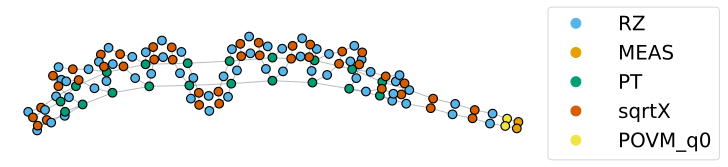

In [52]:
fig = (tmp_s & produce_LPDO(initial_guess & X_guess)).draw(
    show_inds=True,
    node_size=75,
    node_outline_size=1.15,
    node_outline_darkness=0.0,
    color=["RZ", "MEAS", "PT", "sqrtX", "POVM_q0"],
    figsize=(10, 10),
    iterations=10000,
    initial_layout="kamada_kawai",
    return_fig=True,
)

In [53]:
mode = "X_decomp"

In [54]:
iterations = int(no_epochs * len(training_data_flat) / batch_size)

In [55]:
optmzr = TNOptimizer(
    instructions[mode][
        "initial_tn"
    ],  # our initial input, the tensors of which to optimize
    loss_fn=compute_likelihood,
    causality_fn=causality_keys_to_op_arrays,
    causality_key_size=200,
    training_data=np.array(training_data_flat),
    training_sequences=instructions[mode]["training_seqs"],
    Lx=Lx,
    Ly=Ly,
    validation_data=list(val_data),
    validation_sequences=instructions[mode]["val_seqs"],
    batch_size=batch_size,
    loss_constants={},  # this is a constant TN to supply to loss_fn
    loss_kwargs={
        "kappa": 1,
        "opt": "auto-hq",
        "X_decomp": instructions[mode]["likelihood_const"],
    },
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="adam",  # supplied to scipy.minimize
    progbar=True,
)

In [56]:
pepo_opt = optmzr.optimize(3 * iterations)  # regular

  0%|          | 0/57600 [00:00<?, ?it/s]

+0.2828455 [best loss: +0.2818782] [best val: +0.2940784; (9117)]:  16%|█▋        | 9360/57600 [16:30<1:25:06,  9.45it/s]


In [64]:
optmzr.val_best - v_data_entropy

7.366519081258849e-05

In [65]:
print(optmzr._n)
print(np.argmin(optmzr.val_losses))

9360
9117


In [66]:
best_val_mpo = optmzr.best_val_mpo

In [67]:
v_predictions = compute_probabilities(
    optmzr.best_val_mpo,
    instructions[mode]["val_seqs"],
    X_decomp=instructions[mode]["likelihood_const"],
    opt="auto-hq",
)
v_predictions = sum(val_data) * v_predictions / sum(v_predictions)
print(-(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(v_predictions)))

0.2940575262007291


In [68]:
v_predictions_norm = []
for i in range(300):
    tmp_v = v_predictions[2 * i : 2 * (i + 1)]
    tmp_v = tmp_v / sum(tmp_v)
    for v in tmp_v:
        v_predictions_norm.append(v)
v_predictions_norm = np.array(v_predictions_norm)

In [69]:
describe(np.abs(np.array(val_data) - v_predictions_norm))

DescribeResult(nobs=600, minmax=(7.516145706176758e-05, 0.021266281604766846), mean=0.004350978154689073, variance=1.3183935695311852e-05, skewness=1.3581860611126897, kurtosis=2.133706642147472)

In [70]:
no_batches = optmzr._nBatches
epoch_losses = [
    optmzr.losses[no_batches - 1 + no_batches * i]
    for i in range(int(optmzr._n / no_batches))
]
epoch_val_losses = [
    optmzr.val_losses[no_batches - 1 + no_batches * i]
    for i in range(int(optmzr._n / no_batches))
]

Text(0.5, 0, 'Epoch')

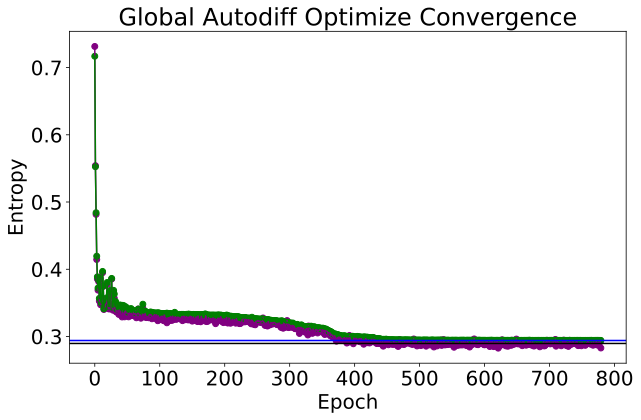

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, color="purple")
plt.plot(epoch_val_losses, color="green")
plt.scatter(range(len(epoch_losses)), epoch_losses, color="purple")
plt.scatter(range(len(epoch_val_losses)), epoch_val_losses, color="green")
plt.axhline(data_entropy, color="black")
plt.axhline(v_data_entropy, color="blue")
plt.title("Global Autodiff Optimize Convergence")
plt.ylabel("Entropy")
# plt.ylim(0.26,0.32)
plt.xlabel("Epoch")

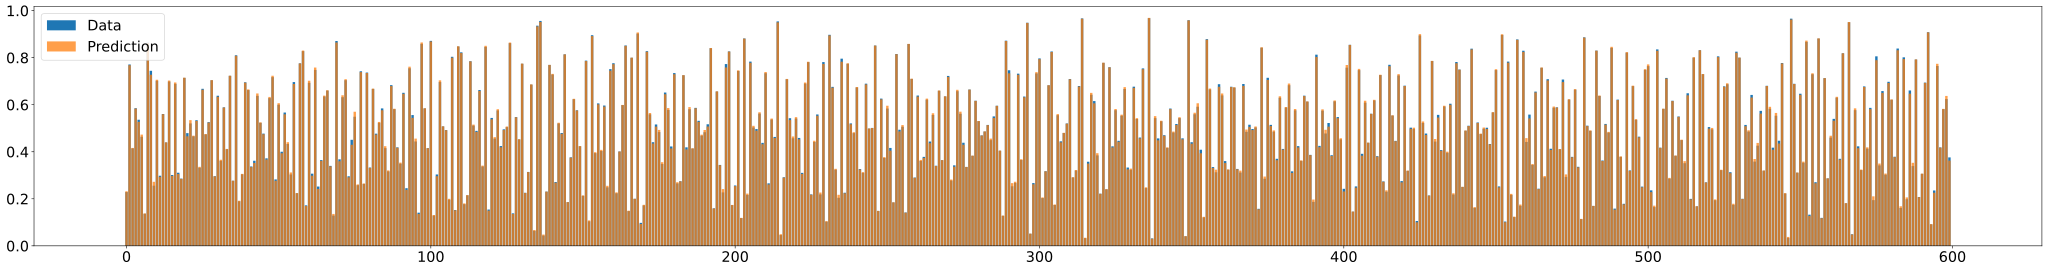

In [72]:
plt.figure(figsize=(50, 6))
plt.bar(range(len(val_data)), val_data, label="Data")
plt.bar(range(len(val_data)), v_predictions_norm, alpha=0.75, label="Prediction")
plt.legend(loc="upper left")
plt.show()

In [95]:
from dynamical_decoupling import *
from DD_optimize import TNOptimizer as TNOptimizer_circ

In [96]:
DD_optmzr = TNOptimizer_circ(
    xy8_seed,  # our initial input, the tensors of which to optimize
    loss_fn=evaluate_DD_sequence,
    loss_constants={
        "PT_est": produce_LPDO(best_val_mpo)
    },  # this is a constant TN to supply to loss_fn
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="L-BFGS-B",  # supplied to scipy.minimize
)

In [97]:
test_opt = DD_optmzr.optimize_basinhopping(5000, 5)
DD_optmzr.optimizer = "adam"
test_opt = DD_optmzr.optimize(5000)

+0.039273109287 [best: +0.034486152232] :   2%|▏         | 2580/150000 [01:01<58:39, 41.89it/s]   
+0.030809391290 [best: +0.030791085213] : : 5001it [00:10, 490.20it/s]                        


In [98]:
opt_params = [test_opt.tensors[i].params for i in range(3 * NSTEPS)]

In [99]:
opt_params_ordered = [opt_params[3 * i : 3 * (i + 1)] for i in range(NSTEPS)]
for i in range(NSTEPS):
    opt_params_ordered[i].reverse()

In [100]:
opt_network = params_to_rz_PTN(np.array(opt_params_ordered))

In [103]:
evaluate_DD_sequence(opt_network, produce_LPDO(best_val_mpo))

Array(0.03082247, dtype=float32)

In [105]:
evaluate_DD_sequence(xy8_seed, produce_LPDO(best_val_mpo))

Array(3.479882, dtype=float32)

In [107]:
val_TNs = [params_to_rz_tensor(u3_to_rz_params(P), shift=0) for P in v_params]
val_TNs = [unparametrise_TN(P) for P in val_TNs]
val_Us = [np.array(make_unitary(*V)) for V in v_params]
ideal_val_outs = [U @ ideal_input @ U.conj().T for U in val_Us]


def test_DD_sequence(param_seq, PT_est):
    # PT_est in LPDO form
    trace_dists = []
    for i in range(len(val_TNs)):
        tmp_op = param_seq & val_TNs[i] & meas_TN
        output_DM = (
            (tmp_op & PT_est)
            .contract(output_inds=(f"bo{NSTEPS+1}_q0", f"ko{NSTEPS+1}_q0"))
            .data
        )
        output_DM = output_DM / np.trace(output_DM)
        tmp_dist = 0.5 * np.linalg.norm(output_DM - ideal_val_outs[i], "nuc")
        trace_dists.append(tmp_dist)

    return trace_dists

In [110]:
opt_difs = test_DD_sequence(opt_network, produce_LPDO(best_val_mpo))  # states
XY_difs = test_DD_sequence(xy8_seed, produce_LPDO(best_val_mpo))
ID_difs = test_DD_sequence(id_seed, produce_LPDO(best_val_mpo))

In [111]:
import pandas as pd

columns = {"identity": ID_difs, "XY": XY_difs, "optimised": opt_difs}
DD_data_df = pd.DataFrame(data=columns)

In [112]:
plt.rcdefaults()

sns.set_palette("deep")
sns.set_style("whitegrid")

In [113]:
def plot_identity(data_frame, ax, minval=0.05):
    data_from = 50

    sorted_data_frame = data_frame.sort_values("identity", ascending=False)
    data_size = 100 - data_from

    ax.scatter(
        range(data_size),
        sorted_data_frame["identity"][data_from:],
        alpha=0.75,
        label="Idle",
        s=7,
        color="C2",
    )
    # ax.errorbar(range(100), sorted_data_frame['identity'], yerr = y_err, elinewidth = 0.1, ecolor='black', capsize=3, capthick=0.1)
    ax.plot(
        range(data_size),
        [
            np.median(sorted_data_frame["identity"][data_from:])
            for i in range(data_size)
        ],
        "--",
        color="C2",
    )

    X = np.median(sorted_data_frame["identity"][data_from:])
    ax.text(
        data_size - 0.5,
        X,
        f"{X:.2f}",
        color="C2",
        verticalalignment="center",
        horizontalalignment="left",
    )

    ax.fill_between(
        range(data_size),
        [minval for i in range(data_size)],
        list(sorted_data_frame["identity"][data_from:]),
        alpha=0.075,
        color="green",
    )

    # ax.set_xlabel('Sequence Number')
    # ax.set_ylabel('Distance from Ideal')

    return None


def plot_DD(data_frame, ax, minval=0.05):

    data_from = 50
    data_size = 100 - data_from
    sorted_data_frame = data_frame.sort_values("identity", ascending=False)

    ax.scatter(
        range(data_size),
        sorted_data_frame["XY"][data_from:],
        alpha=0.75,
        label="XY4",
        s=7,
    )
    ax.scatter(
        range(data_size),
        sorted_data_frame["optimised"][data_from:],
        alpha=0.75,
        label="Opt",
        s=7,
    )

    ax.plot(
        range(data_size),
        [np.median(sorted_data_frame["XY"][data_from:]) for i in range(data_size)],
        "--",
    )
    X = np.median(sorted_data_frame["XY"][data_from:])
    ax.text(
        data_size - 0.5,
        X,
        f"{X:.2f}",
        color="C0",
        verticalalignment="center",
        horizontalalignment="left",
    )

    ax.plot(
        range(data_size),
        [
            np.median(sorted_data_frame["optimised"][data_from:])
            for i in range(data_size)
        ],
        "--",
    )
    X = np.median(sorted_data_frame["optimised"][data_from:])
    ax.text(
        data_size - 0.5,
        X,
        f"{X:.2f}",
        color="C1",
        verticalalignment="center",
        horizontalalignment="left",
    )

    ax.fill_between(
        range(data_size),
        [minval for i in range(data_size)],
        list(sorted_data_frame["XY"][data_from:]),
        alpha=0.075,
        color="blue",
    )
    ax.fill_between(
        range(data_size),
        [minval for i in range(data_size)],
        list(sorted_data_frame["optimised"][data_from:]),
        alpha=0.075,
        color="orange",
    )

    ax.set_xlabel("Sequence Number")
    # ax.set_ylabel('Trace distance from Ideal')

    return None

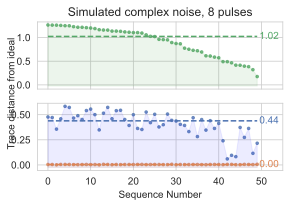

In [114]:
data_from = 50

data_frame = DD_data_df
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 3))

axs[0].set_title(f"Simulated complex noise, 8 pulses")
# ax.semilogy()
# Plot data using your function
minval = np.min(data_frame["optimised"]) - 0.025

plot_identity(data_frame, axs[0], minval=minval)
plot_DD(data_frame, axs[1], minval)

axs[0].set_xlim(None, 5 + (100 - data_from))

fig.text(0.005, 0.55, "Trace distance from ideal", va="center", rotation="vertical")

plt.subplots_adjust(hspace=0.05)
# Adjust layout for better spacing
plt.tight_layout()


# plt.savefig("sim-test-fig.pdf", bbox_inches="tight")
# Show the plot
plt.show()